TODOS / Questions:
- Determine how input process will work
- (Input QC Check) determine how to check all variables and years
- (Comparison of EDAM DOF) how will we know which version to pull from sql (I think it's in sql?)
- (Threshold Analysis) Determine how to handle division by 0 cases where the total is 0 (currently just ignoring them)
- (Threshold Analysis) Determine whether we should look for both value and percentage thresholds, or just one of them
- (Trend Analysis) How do we want to create visualizations of all features?
    - What tool do we use? Currently Matplotlib
    - What geo_level do we do it for? Currently just Region level...

# Part Two

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pyodbc
import glob
import copy
import PySimpleGUI as sg
import traceback
import xlsxwriter
import sys

In [2]:
# Important to avoid Latex formatting (with dollar signs)
pd.options.display.html.use_mathjax = False

In [3]:
# Inputs
comparison = True # Bool
first_ID = 'DS41' # string
second_ID = 'DS35' # string

default_folder = './outputs/'

In [4]:
# use this cell to get column formatting for code

# for col in mgra_35.columns:
#     print(f"'{col}': ...,")

## Importing / downloading data

In [5]:
if comparison:
    ...

In [6]:
#%run Part_1-modularized_v4.ipynb

In [7]:
file_list = [
    f'cpa_both_{first_ID}_{second_ID}.csv',
    f'cpa_diff_{first_ID}_minus_{second_ID}.csv',
    f'cpa_ind_{first_ID}.csv',
    f'cpa_ind_{second_ID}.csv',
    f'jur_both_{first_ID}_{second_ID}.csv',
    f'jur_diff_{first_ID}_minus_{second_ID}.csv',
    f'jur_ind_{first_ID}.csv',
    f'jur_ind_{second_ID}.csv',
    f'mgra_both_{first_ID}_{second_ID}.csv',
    f'mgra_diff_{first_ID}_minus_{second_ID}.csv',
    f'mgra_ind_{first_ID}.csv',
    f'mgra_ind_{second_ID}.csv',
    f'region_both_{first_ID}_{second_ID}.csv',
    f'region_diff_{first_ID}_minus_{second_ID}.csv',
    f'region_ind_{first_ID}.csv',
    f'region_ind_{second_ID}.csv',
]

In [8]:
entries = os.scandir(default_folder)
available_files = [file.name for file in list(entries) if first_ID in file.name or second_ID in file.name]
needed_files = [file for file in file_list if file not in available_files]
needed_files

[]

In [9]:
# Option 1: Run code from Part 1 script to get needed files

In [10]:
mgra_first = pd.read_csv(default_folder + f'mgra_ind_{first_ID}.csv').groupby(['mgra', 'year']).sum()
mgra_second = pd.read_csv(default_folder + f'mgra_ind_{second_ID}.csv').groupby(['mgra', 'year']).sum()

cpa_first = pd.read_csv(default_folder + f'cpa_ind_{first_ID}.csv').groupby(['cpa', 'year']).sum()
cpa_second = pd.read_csv(default_folder + f'cpa_ind_{second_ID}.csv').groupby(['cpa', 'year']).sum()

jur_first = pd.read_csv(default_folder + f'jur_ind_{first_ID}.csv').groupby(['jurisdiction', 'year']).sum()
jur_second = pd.read_csv(default_folder + f'jur_ind_{second_ID}.csv').groupby(['jurisdiction', 'year']).sum()

reg_first = pd.read_csv(default_folder + f'region_ind_{first_ID}.csv')
reg_second = pd.read_csv(default_folder + f'region_ind_{second_ID}.csv')

mgra_both = pd.read_csv(default_folder + f'mgra_both_{first_ID}_{second_ID}.csv').groupby(['mgra', 'year']).sum()
mgra_diff = pd.read_csv(default_folder + f'mgra_diff_{first_ID}_minus_{second_ID}.csv').groupby(['mgra', 'year']).sum()

In [11]:
housing_cols = [
    'hs',
    'hs_Single_Family',
    'hs_Multiple_Family',
    'hs_Mobile_Homes',
    'Household Population (hh)',
    'hh_Single_Family',
    'hh_Multiple_Family',
    'hh_Mobile_Homes',
    'gq_civ',
    'Group Quarters - Military (gq_mil)',    
]

income_cols = [
    'Less than $15,000',
    '$15,000 to $29,999',
    '$30,000 to $44,999',
    '$45,000 to $59,999',
    '$60,000 to $74,999',
    '$75,000 to $99,999',
    '$100,000 to $124,999',
    '$125,000 to $149,999',
    '$150,000 to $199,999',
    '$200,000 or more',
]

## Input QC Check

In [12]:
# TODO: check that all the variables and years were successfully loaded (Reference Table A)
# Hardcode it with yml file maybe

## Internal Consistency Checks

Check if the totals at mgra, jurisdiction, and region level are consistent.

In [13]:
def compare_totals(mgra_df, cpa_df, jur_df, region_df):
    """
    Aggregates sum of values by year in mgra, cpa, jurisdiction, and region level and compares them together to
    see if they match.
    """
    mgra_totals = mgra_df.groupby('year').sum().values
    cpa_totals = cpa_df.groupby('year').sum().values
    jur_totals = jur_df.groupby('year').sum().values
    reg_totals = region_df.set_index('year').values
    
    return {'mgra_df equal to cpa_df': np.isclose(mgra_totals, cpa_totals).all(),'mgra_df equal to jur_df': np.isclose(mgra_totals, jur_totals).all(), 'mgra_df equal to reg_df': np.isclose(mgra_totals, reg_totals).all()}

In [14]:
compare_totals(mgra_first, cpa_first, jur_first, reg_first)

{'mgra_df equal to cpa_df': False,
 'mgra_df equal to jur_df': False,
 'mgra_df equal to reg_df': True}

## Comparison of EDAM total population forecast with California Department of Finance (Cal DOF) forecast

more context here: https://sandag.sharepoint.com/qaqc/_layouts/15/Doc.aspx?sourcedoc={b24ae5c1-9536-4de5-a6fd-bb2860a98fcf}&action=edit&wd=target%28Untitled%20Section.one%7C5e99c4cf-2421-42e4-b4d3-85012f1cee55%2FComments%20on%20DOF%20Data%7C56d66d69-1259-4679-b2c7-0997e99786b2%2F%29

dof data: https://dof.ca.gov/forecasting/Demographics/projections/

In [15]:
# dof files in sql socioec_data database (determine how to select correct version)

## Threshold Analysis

### Row-wise yearly difference threshold (individual)

In [16]:
# TODO: decide how to handle percentage threshold NaN values by 0 division

In [17]:
year_thresholds = {
    'taz': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hs': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hs_Single_Family': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hs_Multiple_Family': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hs_Mobile_Homes': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'Household Population (hh)': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hh_Single_Family': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hh_Multiple_Family': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hh_Mobile_Homes': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'gq_civ': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'Group Quarters - Military (gq_mil)': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'Less than $15,000': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$15,000 to $29,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$30,000 to $44,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$45,000 to $59,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$60,000 to $74,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$75,000 to $99,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$100,000 to $124,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$125,000 to $149,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$150,000 to $199,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$200,000 or more': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hhs': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'pop': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hhp': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_Agricultural_and_Extractive': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_const_non_bldg_prod': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_const_non_bldg_Office': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_utilities_prod': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_utilities_Office': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_const_bldg_prod': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_const_bldg_Office': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_Manufacturing_prod': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_Manufacturing_Office': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_whsle_whs': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_trans': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_retail': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_prof_bus_svcs': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_prof_bus_svcs_bldg_maint': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_pvt_ed_k12': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_pvt_ed_post_k12_Other_Residential': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_health': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_personal_svcs_Office': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_amusement': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_hotel': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_restaurant_bar': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_personal_svcs_retail': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_religious': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_pvt_hh': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_state_local_Government_ent': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_fed_non_Military': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_fed_Military': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_state_local_Government_blue': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_state_local_Government_white': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_public_ed': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_own_occ_dwell_mgmt': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_fed_Government_accts': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_st_lcl_Government_accts': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_cap_accts': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_total': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'enrollgradekto8': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'enrollgrade9to12': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'collegeenroll': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'othercollegeenroll': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'adultschenrl': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'ech_dist': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hch_dist': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'pseudomsa': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'parkarea': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hstallsoth': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hstallssam': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hparkcost': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'numfreehrs': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'dstallsoth': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'dstallssam': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'dparkcost': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'mstallsoth': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'mstallssam': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'mparkcost': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'totint': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'duden': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'empden': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'popden': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'retempden': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'totintbin': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'empdenbin': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'dudenbin': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'zip09': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'parkactive': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'openspaceparkpreserve': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'beachactive': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'budgetroom': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'economyroom': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'luxuryroom': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'midpriceroom': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'upscaleroom': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hotelroomtotal': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'luz_id': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'truckregiontype': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'district27': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'milestocoast': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'acres': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'effective_acres': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'land_acres': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
}

In [20]:
def yearly_diff_threshold(df, threshold_dict):
    """
    input: multi-index dataframe (index = (geo_level, year)), columns to check threshold in,
    value threshold (numeric), percentage threshold (numeric value in {0,1})
    
    output: rows of the input multi-index dataframe with yearly differences outside the
    designated threshold (inclusive)
    """
    
    years = list(df.index.get_level_values(1).unique())
    year_diffs = {}

    index=0
    while index < len(years)-1:
        year_diffs[years[index+1]] = f"{str(years[index])}-{str(years[index+1])}"
        index+=1
        
    renamed_df = df.groupby(level=0).diff().rename(index=year_diffs).dropna(how='all')
    non_2016_df = df[df.index.get_level_values('year') != 2016].rename(index=year_diffs)
    percentage_df = renamed_df.div(non_2016_df).fillna(float('inf'))
    
    perc_condition = pd.DataFrame([abs(percentage_df[key]) >= val['percentage_threshold'] for key, val in threshold_dict.items()]).T.all(axis=1)
    value_condition = pd.DataFrame([abs(renamed_df[key]) >= val['value_threshold'] for key, val in threshold_dict.items()]).T.all(axis=1)
    
    renamed_df['Flag'] = (perc_condition & value_condition)
    
    return renamed_df

In [21]:
a = yearly_diff_threshold(mgra_first, year_thresholds)

In [22]:
a[a['Flag']]#.shape

taz   hs  hs_Single_Family  hs_Multiple_Family  \
mgra  year                                                        
1     2016-2018  0.0  0.0               0.0                 0.0   
      2018-2020  0.0  0.0               0.0                 0.0   
      2020-2023  0.0  1.0               1.0                 0.0   
      2023-2025  0.0  0.0               0.0                 0.0   
      2025-2026  0.0  0.0               0.0                 0.0   
...              ...  ...               ...                 ...   
23002 2030-2032  0.0  0.0               0.0                 0.0   
      2032-2035  0.0  0.0               0.0                 0.0   
      2035-2040  0.0  0.0               0.0                 0.0   
      2040-2045  0.0  0.0               0.0                 0.0   
      2045-2050  0.0  0.0               0.0                 0.0   

                 hs_Mobile_Homes  Household Population (hh)  hh_Single_Family  \
mgra  year                                                                      
1     2016-2018              0.0                        0.0               0.0   
      2018-2020              0.0                        0.0               0.0   
      2020-2023              0.0                        0.0               0.0   
      2023-2025              0.0                        0.0               0.0   
      2025-2026              0.0                        0.0               0.0   
...                          ...                        ...               ...   
23002 2030-2032              0.0                        0.0               0.0   
      2032-2035              0.0                        0.0               0.0   
      2035-2040              0.0                        4.0               1.0   
      2040-2045              0.0                        7.0               2.0   
      2045-2050              0.0                        1.0               0.0   

                 hh_Multiple_Family  hh_Mobile_Homes  gq_civ  ...  \
mgra  year                                                    ...   
1     2016-2018                 0.0              0.0     0.0  ...   
      2018-2020                 0.0              0.0     0.0  ...   
      2020-2023                 0.0              0.0     0.0  ...   
      2023-2025                 0.0              0.0     0.0  ...   
      2025-2026                 0.0              0.0     0.0  ...   
...                             ...              ...     ...  ...   
23002 2030-2032                 0.0              0.0     0.0  ...   
      2032-2035                 0.0              0.0     0.0  ...   
      2035-2040                 3.0              0.0     0.0  ...   
      2040-2045                 5.0              0.0     0.0  ...   
      2045-2050                 1.0              0.0     0.0  ...   

                 upscaleroom  hotelroomtotal  luz_id  truckregiontype  \
mgra  year                                                              
1     2016-2018          0.0             0.0     0.0              0.0   
      2018-2020          0.0             0.0     0.0              0.0   
      2020-2023          0.0             0.0     0.0              0.0   
      2023-2025          0.0             0.0     0.0              0.0   
      2025-2026          0.0             0.0     0.0              0.0   
...                      ...             ...     ...              ...   
23002 2030-2032          0.0             0.0     0.0              0.0   
      2032-2035          0.0             0.0     0.0              0.0   
      2035-2040          0.0             0.0     0.0              0.0   
      2040-2045          0.0             0.0     0.0              0.0   
      2045-2050          0.0             0.0     0.0              0.0   

                 district27  milestocoast  acres  effective_acres  land_acres  \
mgra  year                                                                      
1     2016-2018         0.0           0.0    0.0              0.0         0.0   


### DS_ID difference (comparison)

In [23]:
ds_thresholds = {
    'taz': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hs': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hs_Single_Family': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hs_Multiple_Family': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hs_Mobile_Homes': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'Household Population (hh)': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hh_Single_Family': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hh_Multiple_Family': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hh_Mobile_Homes': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'gq_civ': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'Group Quarters - Military (gq_mil)': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'Less than $15,000': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$15,000 to $29,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$30,000 to $44,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$45,000 to $59,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$60,000 to $74,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$75,000 to $99,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$100,000 to $124,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$125,000 to $149,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$150,000 to $199,999': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    '$200,000 or more': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hhs': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'pop': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hhp': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_Agricultural_and_Extractive': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_const_non_bldg_prod': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_const_non_bldg_Office': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_utilities_prod': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_utilities_Office': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_const_bldg_prod': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_const_bldg_Office': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_Manufacturing_prod': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_Manufacturing_Office': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_whsle_whs': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_trans': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_retail': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_prof_bus_svcs': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_prof_bus_svcs_bldg_maint': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_pvt_ed_k12': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_pvt_ed_post_k12_Other_Residential': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_health': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_personal_svcs_Office': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_amusement': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_hotel': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_restaurant_bar': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_personal_svcs_retail': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_religious': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_pvt_hh': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_state_local_Government_ent': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_fed_non_Military': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_fed_Military': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_state_local_Government_blue': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_state_local_Government_white': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_public_ed': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_own_occ_dwell_mgmt': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_fed_Government_accts': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_st_lcl_Government_accts': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_cap_accts': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'emp_total': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'enrollgradekto8': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'enrollgrade9to12': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'collegeenroll': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'othercollegeenroll': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'adultschenrl': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'ech_dist': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hch_dist': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'pseudomsa': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'parkarea': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hstallsoth': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hstallssam': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hparkcost': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'numfreehrs': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'dstallsoth': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'dstallssam': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'dparkcost': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'mstallsoth': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'mstallssam': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'mparkcost': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'totint': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'duden': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'empden': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'popden': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'retempden': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'totintbin': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'empdenbin': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'dudenbin': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'zip09': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'parkactive': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'openspaceparkpreserve': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'beachactive': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'budgetroom': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'economyroom': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'luxuryroom': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'midpriceroom': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'upscaleroom': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'hotelroomtotal': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'luz_id': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'truckregiontype': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'district27': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'milestocoast': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'acres': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'effective_acres': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
    'land_acres': {
        'value_threshold': 0, 'percentage_threshold': 0
    },
}

In [24]:
def ds_diff_threshold(diff_df, mgra_second, threshold_dict):
    """
    input: Multi-index diff dataframe (index = (geo_level, year)), Multi-index first_ID_df
    dataframe (index = (geo_level, year)), column(s) to check threshold, value threshold (numeric),
    percentage threshold (numeric value in {0,1})
    
    output: rows of the input multi-index dataframe with DS differences outside the
    designated thresholds (inclusive)
    """
    
    mgra_second.columns = [f"{col}_diff" for col in mgra_second.columns]
    
    percentage_df = diff_df.div(mgra_second).fillna(float('inf'))
    
    perc_condition = pd.DataFrame([abs(percentage_df[f'{key}_diff']) >= val['percentage_threshold'] for key, val in threshold_dict.items()]).T.all(axis=1)
    value_condition = pd.DataFrame([abs(diff_df[f'{key}_diff']) >= val['value_threshold'] for key, val in threshold_dict.items()]).T.all(axis=1)
    
    diff_df['Flag'] = (perc_condition & value_condition)
    
    return diff_df
    
    if type(column) == str:
        return diff_df[(diff_df[column].abs() >= value_threshold) & (percentage_df[column].abs() >= percentage_threshold)]
    elif type(column) == list:
        return diff_df[(diff_df[column].abs() >= value_threshold).any(axis=1) | (percentage_df[column].abs() >= percentage_threshold).any(axis=1)] # Should this be .all()?
    else:
        print((diff_df.abs() >= value_threshold).any(axis=1) & (percentage_df.abs() >= percentage_threshold).any(axis=1))
        return diff_df[(diff_df.abs() >= value_threshold).any(axis=1) & (percentage_df.abs() >= percentage_threshold).any(axis=1)]

In [25]:
ds_diff_example = ds_diff_threshold(mgra_diff, mgra_second, ds_thresholds)

In [26]:
ds_diff_example

taz_diff  hs_diff  hs_Single_Family_diff  hs_Multiple_Family_diff  \
mgra  year                                                                      
1     2016         0        0                      0                        0   
      2018         0        0                      0                        0   
      2020         0        0                      0                        0   
      2023         0        0                      0                        0   
      2025         0        0                      0                        0   
...              ...      ...                    ...                      ...   
23002 2032         0        0                      0                        0   
      2035         0        0                      0                        0   
      2040         0        0                      0                        0   
      2045         0        0                      0                        0   
      2050         0        0                      0                        0   

            hs_Mobile_Homes_diff  Household Population (hh)_diff  \
mgra  year                                                         
1     2016                     0                               0   
      2018                     0                               0   
      2020                     0                               0   
      2023                     0                               0   
      2025                     0                               0   
...                          ...                             ...   
23002 2032                     0                              -2   
      2035                     0                              -2   
      2040                     0                              -4   
      2045                     0                               2   
      2050                     0                               1   

            hh_Single_Family_diff  hh_Multiple_Family_diff  \
mgra  year                                                   
1     2016                      0                        0   
      2018                      0                        0   
      2020                      0                        0   
      2023                      0                        0   
      2025                      0                        0   
...                           ...                      ...   
23002 2032                      3                       -5   
      2035                      3                       -5   
      2040                      2                       -6   
      2045                      3                       -1   
      2050                      3                       -2   

            hh_Mobile_Homes_diff  gq_civ_diff  ...  upscaleroom_diff  \
mgra  year                                     ...                     
1     2016                     0            0  ...                 0   
      2018                     0            0  ...                 0   
      2020                     0            0  ...                 0   
      2023                     0            0  ...                 0   
      2025                     0            0  ...                 0   
...                          ...          ...  ...               ...   
23002 2032                     0            0  ...                 0   
      2035                     0            0  ...                 0   
      2040                     0            0  ...                 0   
      2045                     0            0  ...                 0   
      2050                     0            0  ...                 0   

            hotelroomtotal_diff  luz_id_diff  truckregiontype_diff  \
mgra  year                                                           
1     2016                    0            0                     0   
      2018                    0            0                     0   
      2020                    0            0     

## Trend Analysis

Visually analyze forecast trends for years of interest to identify any unexpected trends. 

Decision items: Should output from this check be pushed into PowerBI? 

In [ ]:
from powerbiclient import Report, models

In [ ]:
from powerbiclient.authentication import DeviceCodeLoginAuthentication

In [ ]:
# Not sure how we can visualize all features

In [ ]:
plt.scatter(reg_35['year'], reg_35['hs'])

## Parking Formula Checks

More info: https://sandag.sharepoint.com/qaqc/_layouts/15/Doc.aspx?sourcedoc={276bc2d7-75c5-4865-b7ab-6032aa492e45}&action=edit&wd=target%28Untitled%20Section.one%7Cd0bb8408-498b-4411-9b1d-7704a49975eb%2FDecision%20Tree-V2%7C59dc5bcf-f997-4640-9040-5fdfde0e3eee%2F%29

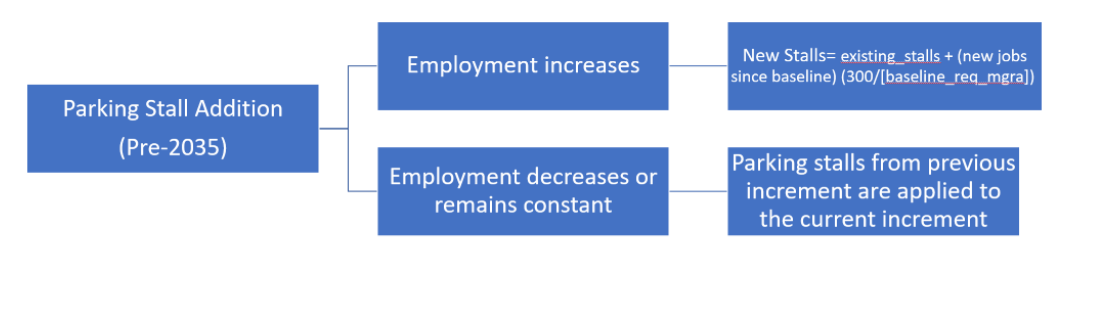

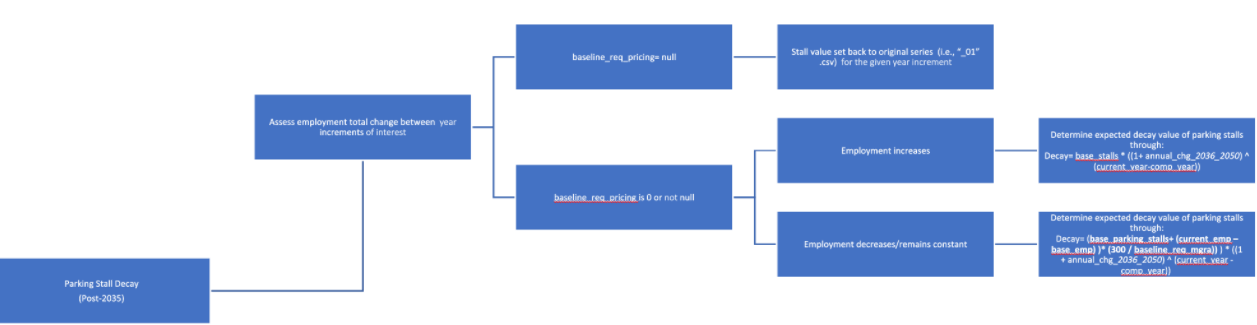

In [ ]:
def parking_formula(df):
    return all

In [ ]:
parking_formula(mgra_first)

## Custom Checks

## Spatial Density

## Input output check- Check if inputs and outputs for housing/scheduled developments are consistent (cannot be automated)

# GUI Code (Usage unconfirmed)

In [ ]:
column_options = housing_cols

In [ ]:
def base_window():
    """
    Creates SimplePyGUI window that enables user to select a single DS_ID along with desired outputs. The window will
    also have a console section where any output notes or errors will be displayed.
    Returns click event as well as selected values (might remove return values since no purpose as of now).
    """
    sg.theme('SandyBeach')
    lb_options = sg.Listbox(values=column_options, select_mode='multiple', size=(20, len(column_options)+1), key='column_options')
    lb_options_2 = sg.Listbox(values=column_options, select_mode='multiple', size=(20, len(column_options)+1), key='column_options_2')
    
    def select_all_options():
        lb_options.set_value(column_options)
        return
    def deselect_all_options():
        lb_options.set_value([])
        return
    
#     def select_all_ds():
#         lb_ds.set_value(list(config.keys())[:-1])
#         return
#     def deselect_all_ds():
#         lb_ds.set_value([])
#         return
        
    layout_individual = [
#         [sg.Button('Back', key='Back')],
#         [sg.Text('Please Select DS_ID(s)')],
#         [[sg.Button('Select All', target='individual_ID', key='select_all_ds'), sg.Button('Clear All', target='individual_ID', key='clear_all_ds')], lb_ds],
        [sg.Text('Select Features to Check'), sg.Text('Select Features to Check')],
        [[sg.Button('Select All', target='column_options', key='select_all'), sg.Button('Clear All', target='column_options', key='clear_all'), sg.Button('Select All', target='column_options', key='select_all'), sg.Button('Clear All', target='column_options', key='clear_all')], lb_options, lb_options_2],
        [sg.Submit(key='individual'), sg.Button('Cancel/Close', key='Cancel')],
        [sg.Output(size=(50,20), key='output')]
    ]
    
    window = sg.Window('Individual window', layout_individual, element_justification='c')
    
    while True: # Event Loop
        event, values = window.Read()
        if event in (None, 'Cancel', 'Back'):
            break
        if event == 'select_all':
            select_all_options()
        if event == 'clear_all':
            deselect_all_options()
        if event == 'select_all_ds':
            select_all_ds()
        if event == 'clear_all_ds':
            deselect_all_ds()

    window.Close()
    window['output'].__del__()
    
    return event, values

In [ ]:
base_window()

In [ ]:
def housing_window():
    """
    Creates SimplePyGUI window that enables user to select output path and output option (comparison or individual).
    Returns click event as well as selected values (click event will indicate output option and values will indicate 
    output path).
    """
    layout_first = [ 
        [sg.Text('Please Designate An Output Path (or leave blank to use local outputs folder)')],
        [sg.Text('Output Path', size =(15, 1)), sg.FolderBrowse(key='output-path')],
        [sg.Text('Select An Output Option')],
        [sg.Button(button_text='Comparison', key='comparison-select'),
         sg.Button(button_text='Individual', key='individual-select'),
         sg.Cancel()]
    ]
    
    window = sg.Window('Base window', layout_first, element_justification='c')
    event, values = window.read()
    window.close()

    return event, values

In [ ]:
def income_window():
    """
    Creates SimplePyGUI window that enables user to select output path and output option (comparison or individual).
    Returns click event as well as selected values (click event will indicate output option and values will indicate 
    output path).
    """
    layout_first = [ 
        [sg.Text('Please Designate An Output Path (or leave blank to use local outputs folder)')],
        [sg.Text('Output Path', size =(15, 1)), sg.FolderBrowse(key='output-path')],
        [sg.Text('Select An Output Option')],
        [sg.Button(button_text='Comparison', key='comparison-select'),
         sg.Button(button_text='Individual', key='individual-select'),
         sg.Cancel()]
    ]
    
    window = sg.Window('Base window', layout_first, element_justification='c')
    event, values = window.read()
    window.close()

    return event, values

In [ ]:
def initiate_window():
    """
    Function that initiates the window flow process starting with the base window. Helps coordinate transfer from base
    window to either comparison or individual window based on click event returned from base window.
    """
    sg.theme('SandyBeach')
    
    event, values = base_window()
    output_path = values['output-path']
    while True:
        if event in [None, 'Cancel']:
            return
        if event == 'comparison-select':
            event, values = comparison_window(output_path)
            return
        if event == 'individual-select':
            event, values = individual_window(output_path)
            return

In [ ]:
base_window()